# TO DO:



# Initialization

In [1]:
from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import sys, os, re, csv
import seaborn
import pandas as pd
import loadBehavioralData as ld
%matplotlib inline
seaborn.set(font_scale=2)
seaborn.set_style("ticks")
clrs = seaborn.color_palette(n_colors=7)

# stim1 is left stim0 is right

Select the file to analyse:

In [2]:
# Data Path
path = 'C:/Users/Quentin Gaucher/data/ENS behavior/Gouda/Gouda_session28_190221.csv'


In [3]:
# Constants
intervalDur = 10
hasCorrectionTrials = True

In [4]:
# Functions
def calcMI(respMat):
    eps = np.finfo(float).eps # Bug for log2(0)
    nRow = respMat.shape[0]
    nCol = respMat.shape[1]
    sumX = respMat.sum(axis=0)
    sumY = respMat.sum(axis=1)
    sumX = sumX.flatten()
    sumY = sumY.flatten()
    nTot = respMat.sum()
    MI = 0
    for x in range(nRow):
        for y in range(nCol):
            pxy = respMat[x, y]/nTot
            px = sumY[0][0,x]/sumY.sum()
            py = sumX[0][0,y]/sumX.sum()
            MI = MI + (pxy * np.log2(eps + pxy/(px * py)))
    return MI

def sig_test(p1,n1,p2,n2):
    top = p1 - p2
    phat = (n1*p1 + n2*p2)/(n1+n2)
    bot = np.sqrt(phat*(1-phat)*((1/n1)+(1/n2)))
    return top/bot



# Data Importation

In [5]:
dataObj = ld.dataManage(path,True)
allTrials = dataObj.getTrials()
#dataObj.t_sides
#dataObj.trial
#dataObj.readCSV()
# dataObj.stim_names
#dataObj.getTrials()
#dataObj.path
#dir(dataObj)

In [9]:

f = csv.reader(open(path))

    
rews = []
stims = []
licks = []
pokes = []

for row in f:
    
    for col in row:
        if len(re.findall("rewList:", col))>0:
            t = re.findall("rewList:(.*)", col)[0]
            if t!='':
                tmprews = t.split("-")
                tmprews = [x for x in tmprews if not ("C" in x)] # remove the "C" rewards from list
                rews = rews + tmprews
                
        if len(re.findall("sndList:", col))>0:
            t = re.findall("sndList:(.*)", col)[0]
            
            if t!='':
                stims = stims + t.split("-")
                
        if len(re.findall("lickList:", col))>0:
            t = re.findall("lickList:(.*)", col)[0]
            if t!='':
                t_sides = ["L" if "L" in i else "R" if "R" in i else "C" for i in t.split("-")]
                t_times = [float(re.findall("([0-9]{1,5}.[0-9]{1,5})[R,L,C]",i)[0]) for i in t.split("-")]
                t_ = [[i,j] for i,j in zip(t_times,t_sides)]
                licks = licks + t_
                
        if len(re.findall("pokeList:", col))>0:
            t = re.findall("pokeList:(.*)", col)[0]
            if t!='':
                t_sides = ["L" if "L" in i else "R" if "R" in i else "C" for i in t.split("-")]
                t_times = [float(re.findall("([0-9]{1,5}.[0-9]{1,5})[R,L,C]",i)[0]) for i in t.split("-")]
                t_ = [[i,j] for i,j in zip(t_times,t_sides)]
                pokes = pokes + t_

                
rew_sides = [re.findall("[0-9]{1,5}.{0,2}[0-9]{0,5}([A-z]*)",i)[0] for i in rews]
rew_t = [float(re.findall("([0-9]{1,5}.{0,2}[0-9]{0,5})[A-z]*",i)[0]) for i in rews]
stim_type = [int(re.findall("[0-9]{1,5}.{0,2}[0-9]{0,5}([0,1])",i)[0]) for i in stims]
stim_t = [float(re.findall("([0-9]{1,5}.{0,2}[0-9]{0,5})[A-z]*",i)[0]) for i in stims]
poke_t = [i[0] for i in pokes]
lick_t = [i[0] for i in licks]

harmonic_idxs = np.where(np.array(["kHz" in i for i in stims]))[0]



In [10]:
print(len(poke_t))
#print(len(rews))

#print((poke_t))
#print((rews))

572


# Variable extraction
Filling local variables

In [11]:

# 0 - target - left

rew_sides = np.array(rew_sides)
rew_t = np.array(rew_t)
stim_type = np.array(stim_type)
stim_t = np.array(stim_t)
lick_t = np.array(lick_t)
poke_t = np.array(poke_t)

# print(len(rew_sides))
# print((rew_sides))
# print(len(rew_t))
# print((rew_t))
# print(len(stim_type))
# print((stim_type))
# print(len(stim_t))
# print((stim_t))
# print(len(lick_t))
# print((lick_t))

# Lick time and direction
licktC = np.array(lick_t)[np.where(np.array(licks)=='C')[0]]
licktR = np.array(lick_t)[np.where(np.array(licks)=='R')[0]]
licktL = np.array(lick_t)[np.where(np.array(licks)=='L')[0]]

# Pokes time and direction
pokesC = np.array(poke_t)[np.where(np.array(pokes)=='C')[0]]
pokesR = np.array(poke_t)[np.where(np.array(pokes)=='R')[0]]
pokesL = np.array(poke_t)[np.where(np.array(pokes)=='L')[0]]

# Exclude correction trials

allTrials = []
prevHit = True
for idx,c in enumerate(stim_type):
    hit = False
    corr = False
    # Lick dir
    RL = licktR[np.where((licktR>=stim_t[idx]) * (licktR <= (stim_t[idx]+intervalDur)))[0]]
    LL = licktL[np.where((licktL>=stim_t[idx]) * (licktL <= (stim_t[idx]+intervalDur)))[0]]
    RP = pokesR[np.where((pokesR>=stim_t[idx]) * (pokesR <= (stim_t[idx]+intervalDur)))[0]]
    LP = pokesL[np.where((pokesL>=stim_t[idx]) * (pokesL <= (stim_t[idx]+intervalDur)))[0]]
    
    # # Hit/Miss
    # if c == 0:
    #     if ((len(RL)>0) and (len(LL)>0) and (RL[0] < LL[0])) or ((len(RL)>0) and (len(LL)==0)):
    #         hit = True
    # else:
    #     if ((len(RL)>0) and (len(LL)>0) and (RL[0] > LL[0])) or ((len(LL)>0) and (len(RL)==0)):
    #         hit = True

    # Hit/Miss
    if c == 0:
        if ((len(RP)>0) and (len(LP)>0) and (RP[0] > LP[0])) or ((len(LP)>0) and (len(RP)==0)):
            hit = True
    else:
        if ((len(RP)>0) and (len(LP)>0) and (RP[0] < LP[0])) or ((len(RP)>0) and (len(LP)==0)):
            hit = True

    #Corr trials
    if not prevHit and hasCorrectionTrials:
        corr = True

    isTrial =  sum(harmonic_idxs == idx)

    if not isTrial:
        stimID = 'NA'
    else:
        stimID = stims[idx].split("+")[1]

    trial = ['stim', c, 'stim time', stim_t[idx], 'hit', hit, 'correction trial', corr, 'lickR', RL, 'lickL', LL, 'pokeR', RP, 'pokeL', LP, 'isTrial',isTrial, 'TrialID', stimID]
    allTrials.append(trial)
    prevHit = hit



In [12]:
#allTrials[0]

In [13]:
# len(allTrials)
# for t in allTrials:
#     print([t[1], t[13]])

In [14]:
np.in1d(2,(1,2,4,5))

array([ True])

In [15]:
# allEventTimes = np.concatenate((pokesC, pokesL))
# test = np.concatenate((['a' for i in range(len(pokesC))],['b' for i in range(len(pokesL))]))
# test2 = test[np.argsort(allEventTimes)]
# test2
# allEventTimes.sort()
# allEventTimes

# Session overview
## Plot all events as a function of time

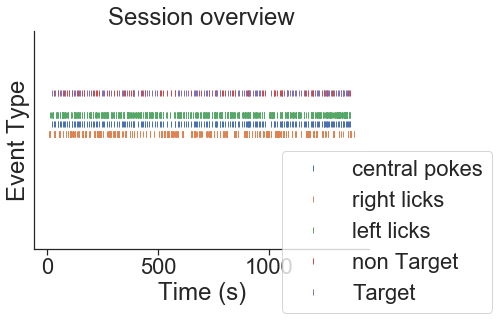

In [16]:

plt.plot(pokesC,[1.5]*len(pokesC),'|',label='central pokes')
plt.plot(licktR,[1.35]*len(licktR),'|',label='right licks')
plt.plot(licktL,[1.65]*len(licktL),'|',label='left licks')
plt.plot(stim_t[np.where(stim_type==1)[0]],
         [2]*len(np.where(stim_type==1)[0]),'|',label='non Target')
plt.plot(stim_t[np.where(stim_type==0)[0]],
         [2]*len(np.where(stim_type==0)[0]),'|',label='Target')
plt.ylim(-.5,3)
plt.yticks([])
plt.xlabel("Time (s)")
plt.ylabel("Event Type")
plt.legend(bbox_to_anchor=(1.4,.5))
plt.title("Session overview")
#plt.xlim(300,600)
seaborn.despine()

## Plot all events aligned on stimulus presentation

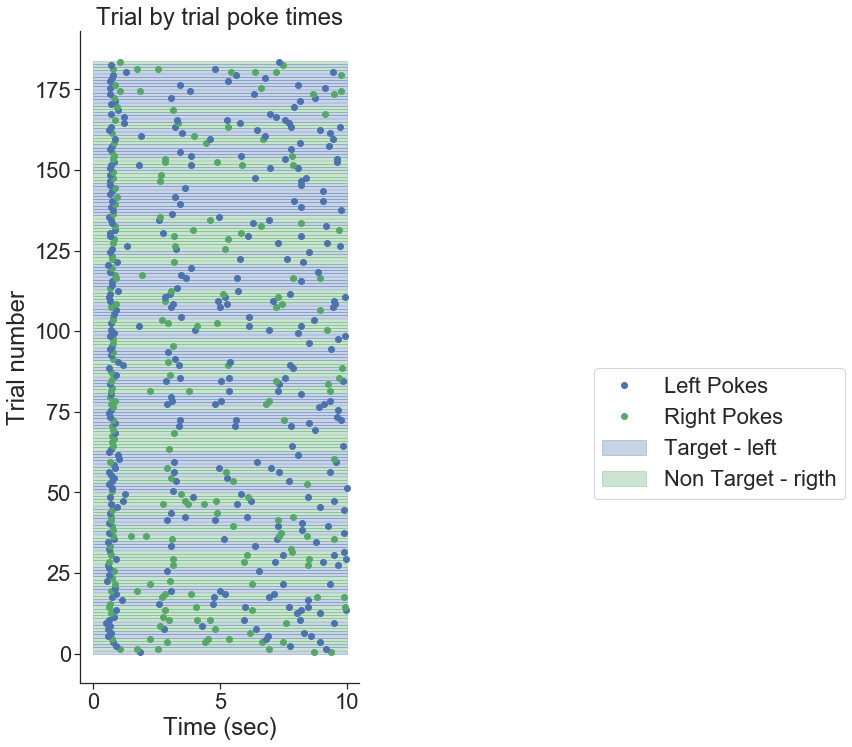

In [17]:
# Align the licks to the central poke. 0 : Central poke, grey dots: Right licks, red dots: Left licks.
# Well trained animals should have a massed number of licks after 0, to the proper direction
# Color on 0 indicates target, red for left, grey for right

# trial = ['stim', c, 'stim time', stim_t[idx], 'hit', hit, 'correction trial', corr, 'lickR', RL, 'lickL', LL, 'pokeR', RP, 'pokeL', LP, 'isTrial',isTrial, 'TrialID', stimID]

plt.figure(figsize=(5,12))
#print(licktC)
#print(licktR)
for count,c in enumerate(allTrials):
    #print(count)
    RL = c[13]
    LL = c[15]
    plt.plot(RL-c[3],[count+.5]*len(RL),'o',color=clrs[2])
    plt.plot(LL-c[3],[count+.5]*len(LL),'o',color=clrs[0],)
    if c[1]==0 and not c[17]:
        plt.fill_between([0,intervalDur],count,count+.95,color=clrs[0],alpha=.3)
    elif c[1]==1 and not c[17]:
        plt.fill_between([0,intervalDur],count,count+.95,color=clrs[2],alpha=.3)
    elif c[1]==0 and c[17]:
        plt.fill_between([0,intervalDur],count,count+.95,color=clrs[4],alpha=.3)
    elif c[1]==1 and c[17]:
        plt.fill_between([0,intervalDur],count,count+.95,color=clrs[5],alpha=.3)

plt.fill_between([0,0],0,0,color=clrs[0],alpha=.3,label = 'Target - left')
plt.fill_between([0,0],0,0,color=clrs[2],alpha=.3,label = 'Non Target - rigth')
#plt.fill_between([0,0],0,0,color=clrs[4],alpha=.3,label = 'Right trial')
#plt.fill_between([0,0],0,0,color=clrs[5],alpha=.3,label = 'Left trial')
plt.plot([],[],'o',color=clrs[0],label = 'Left Pokes')
plt.plot([],[],'o',color=clrs[2],label = 'Right Pokes')
plt.ylabel("Trial number")
plt.xlabel("Time (sec)")
seaborn.despine()
plt.legend(bbox_to_anchor=(1.8,0.5))
plt.title("Trial by trial poke times")
plt.savefig('T2TlickTimes.pdf')

#plt.ylim(0,10)
# plt.xlim(0,3)
# for i in range(10):
#     print(allTrials[i])

In [18]:
len(allTrials)

184

# Performance

In [19]:
# Response matrix first lick
# (Usefull for habituation script, where biased mice get a lot of hits)

# plt.figure(figsize=(5,12))
# #print(licktC)
# #print(licktR)
# count = 0
# nTrialR = 0
# nTrialL = 0
# hitR = 0
# hitL = 0
# for c in stim_t:
#     #print(count)
#     RL = licktR[np.where((licktR>=c) * (licktR <= (c+intervalDur)))[0]]
#     LL = licktL[np.where((licktL>=c) * (licktL <= (c+intervalDur)))[0]]
#     target = stim_type[count]
#     count = count+1
#     if target == 0:
#         nTrialR = nTrialR + 1
#         if ((len(RL)>0) and (len(LL)>0) and (RL[0] < LL[0])) or ((len(RL)>0) and (len(LL)==0)):
#             hitR = hitR + 1
#     else:
#         nTrialL = nTrialL + 1
#         if ((len(RL)>0) and (len(LL)>0) and (RL[0] > LL[0])) or ((len(LL)>0) and (len(RL)==0)):
#             hitL = hitL + 1

# respMat = np.matrix([[hitL/nTrialL, (nTrialL-hitL)/nTrialL],[(nTrialR-hitR)/nTrialR,hitR/nTrialR]])
# plt.matshow(respMat,vmin=0,vmax=1)
# plt.title("Response Matrix")
# plt.xlabel("Behavior")
# plt.ylabel("Stimulus")
# #plt.axis("off")
# print("Response Matrix Values: ")
# print(str(respMat))


# MI = calcMI(respMat)
# print
# print("MI value: " + str(MI))

# print
# print("Diag : " + str(np.mean(np.diag(respMat))))

Response Matrix Values: 
[[0.61111111 0.38888889]
 [0.61363636 0.38636364]]
MI value: 4.844679134520589e-06
Diag : 0.49873737373737376


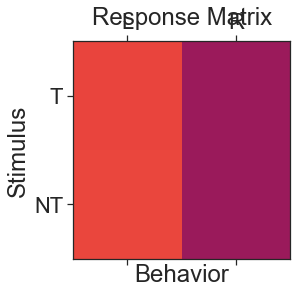

In [20]:
# Response matrix for normal trials (without correction trials)

# trial = ['stim', c, 'stim time', stim_t[idx], 'hit', hit, 'correction trial', corr, 'lickR', RL, 'lickL', LL, 'pokeR', RP, 'pokeL', LP, 'isTrial',isTrial, 'TrialID', stimID]
axYLabels = ['T', 'NT']
axXLabels = ['L', 'R']
nTrialR = 0
nTrialL = 0
hitR = 0
hitL = 0
for t_, trial in enumerate(allTrials):
#     print(trial[15])
    if not trial[17]:
        if trial[7]: # Exclude correction trials
            continue
        if trial[1] == 0:
            nTrialL = nTrialL + 1
            if trial[5]:
                hitL = hitL + 1
        else:
            nTrialR = nTrialR + 1
            if trial[5]:
                hitR = hitR + 1

respMat = np.matrix([[hitL/nTrialL, (nTrialL-hitL)/nTrialL],[(nTrialR-hitR)/nTrialR,hitR/nTrialR]])
figure = plt.figure()
axes = figure.add_subplot(111)
axes.matshow(respMat,vmin=0,vmax=1)
#plt.set_yticklabels(['a' 'b'])
plt.set_cmap('Greys')
plt.title("Response Matrix")
axes.set_yticklabels(['']+axYLabels)
axes.set_xticklabels(['']+axXLabels) 
#figH.axes.set_xticklabels(['a ', 'b'])
plt.xlabel("Behavior")
plt.ylabel("Stimulus")
plt.axes
#plt.axis("off")
print("Response Matrix Values: ")
print(str(respMat))


MI = calcMI(respMat)
print
print("MI value: " + str(MI))

print
print("Diag : " + str(np.mean(np.diag(respMat))))

plt.savefig('CM.pdf')

[Text(-1.0, 1, 'a b')]

In [161]:
# Response matrix for test trials
# trial = ['stim', c, 'stim time', stim_t[idx], 'hit', hit, 
# 'correction trial', corr, 'lickR', RL, 'lickL', LL, 'isTrial',bool, 'trial ID', str]

nTrialR = [0, 0, 0]
nTrialL = [0, 0, 0]
hitR = [0, 0, 0]
hitL = [0, 0, 0]
strStim = ['allHarm', 'midHarm','highHarm', 'Tones']
for t_, trial in enumerate(allTrials):
#     print(trial[15])
    if trial[13]:
        if trial[7]:
            continue
        if trial[1] == 0:
            if 'allHarm' in trial[15]:
                nTrialR[0] = nTrialR[0] + 1
                if trial[5]:
                    hitR[0] = hitR[0] + 1
            if 'midHarm' in trial[15]:
                nTrialR[1] = nTrialR[1] + 1
                if trial[5]:
                    hitR[1] = hitR[1] + 1
            if 'highHarm' in trial[15]:
                nTrialR[2] = nTrialR[2] + 1
                if trial[5]:
                    hitR[2] = hitR[2] + 1
        else:
            if 'allHarm' in trial[15]:
                nTrialL[0] = nTrialL[0] + 1
                if trial[5]:
                    hitL[0] = hitL[0] + 1
            if 'midHarm' in trial[15]:
                nTrialL[1] = nTrialL[1] + 1
                if trial[5]:
                    hitL[1] = hitL[1] + 1
            if 'highHarm' in trial[15]:
                nTrialL[2] = nTrialL[2] + 1
                if trial[5]:
                    hitL[2] = hitL[2] + 1

for st in range(3):
    respMat = np.matrix([[hitL[st]/nTrialL[st], (nTrialL[st]-hitL[st])/nTrialL[st]],[(nTrialR[st]-hitR[st])/nTrialR[st],hitR[st]/nTrialR[st]]])
    plt.matshow(respMat,vmin=0,vmax=1)
    plt.title(strStim[st])
    plt.xlabel("Behavior")
    plt.ylabel("Stimulus")
    #plt.axis("off")
    print("Response Matrix Values: ")
    print(str(respMat))


    MI = calcMI(respMat)
    print
    print("MI value: " + str(MI))

    print
    print("Diag : " + str(np.mean(np.diag(respMat))))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

# Hit / Miss ratio

In [140]:
# trial = ['stim', c, 'stim time', stim_t[idx], 'hit', hit, 
# 'correction trial', corr, 'lickR', RL, 'lickL', LL, 'isTrial',bool, 'trial ID', str]

nTrialR = [0, 0, 0, 0]
nTrialL = [0, 0, 0, 0]
hitR = [0, 0, 0, 0]
hitL = [0, 0, 0, 0]
for t_, trial in enumerate(allTrials):
#     print(trial[15])
    if trial[13]:
        if trial[7]:
            continue
        if trial[1] == 0:
            if 'allHarm' in trial[15]:
                nTrialR[0] = nTrialR[0] + 1
                if trial[5]:
                    hitR[0] = hitR[0] + 1
            if 'midHarm' in trial[15]:
                nTrialR[1] = nTrialR[1] + 1
                if trial[5]:
                    hitR[1] = hitR[1] + 1
            if 'highHarm' in trial[15]:
                nTrialR[2] = nTrialR[2] + 1
                if trial[5]:
                    hitR[2] = hitR[2] + 1
        else:
            if 'allHarm' in trial[15]:
                nTrialL[0] = nTrialL[0] + 1
                if trial[5]:
                    hitL[0] = hitL[0] + 1
            if 'midHarm' in trial[15]:
                nTrialL[1] = nTrialL[1] + 1
                if trial[5]:
                    hitL[1] = hitL[1] + 1
            if 'highHarm' in trial[15]:
                nTrialL[2] = nTrialL[2] + 1
                if trial[5]:
                    hitL[2] = hitL[2] + 1
    else:
        if trial[7]:
            continue
        if trial[1]==0:
            nTrialR[3] = nTrialR[3] + 1
            if trial[5]:
                hitR[3] = hitR[3] + 1
        else:
            nTrialL[3] = nTrialL[3] + 1
            if trial[5]:
                hitL[3] = hitL[3] + 1
            
strStim = ['allHarm', 'midHarm','highHarm', 'Tones']
f, ax = plt.subplots(2,2, sharex=True, sharey=True)
coord = [[0,0],[0,1],[1,0],[1,1]]
for st,a in enumerate(f.axes):
    if nTrialL[st] != 0 and nTrialR[st] != 0:
        a.bar([0,1,2],[hitL[st]/nTrialL[st],hitR[st]/nTrialR[st],(hitL[st]+hitR[st])/(nTrialL[st]+nTrialR[st])],width=.5)
        a.plot([-0.5, 2.5],[0.5, 0.5],color=[0, 0, 0])
    #     ax[st].xticks([0,1,2],["Hit Left","Hit Right","Overall hit"])
    #     ax[st].ylabel("Fraction of hit trial")
        a.set_title(strStim[st])
        seaborn.despine()

# f.subplots_adjust(hspace=0)
# plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [141]:
# Align the licks to the central poke. 0 : Central poke, grey dots: Right licks, red dots: Left licks.
# Well trained animals should have a massed number of licks after 0, to the proper direction
# Color on 0 indicates target, red for left, grey for right

#print(licktC)
#print(licktR)
count = 0
resps = []
for idx,c in enumerate(stim_t):
    try:
        minR = np.min(licktR[np.where((licktR>=c) * (licktR <= (c+10)))[0]])

    except ValueError:
        minR = 1e14
                      
    try:
        minL = np.min(licktL[np.where((licktL>=c) * (licktL <= (c+10)))[0]])

    except ValueError:
        minR = 1e14
    choice = np.argmin([minR,minL,1e8])
    
    #if choice==2:
    #    choice = 99
    resps.append(choice)
    
print("fraction correct B: %s" %(np.mean(np.array(resps)==np.array(stim_type))))
print("fraction correct R: %s" %np.mean((np.array(resps)==np.array(stim_type))[np.where(stim_type==0)]))
print("fraction correct L: %s" %np.mean((np.array(resps)==np.array(stim_type))[np.where(stim_type==1)]))

fraction correct B: 0.5217391304347826
fraction correct R: 0.3541666666666667
fraction correct L: 0.7045454545454546
